### LOAD LIGHTNING MODEL

In [1]:
!pip install pytorch-lightning --quiet
!pip install lightning-bolts --quiet

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch.optim.lr_scheduler import OneCycleLR
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.loggers import TensorBoardLogger
import config
import torch
import torch.optim as optim
import matplotlib

from model import YOLOv3
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    plot_couple_examples,
    accuracy_fn,
    get_loaders,
    non_max_suppression,
    plot_image
)
from loss import YoloLoss
import warnings
warnings.filterwarnings("ignore")

In [3]:
# custom functions for yolo

# loss function for yolov3
loss_fn = YoloLoss()

def model_criterion(out, y,anchors):
    loss = (  loss_fn(out[0], y[0], anchors[0])
            + loss_fn(out[1], y[1], anchors[1])
            + loss_fn(out[2], y[2], anchors[2])
            )
    return loss


# accuracy function for yolov3
def accuracy_fn(y, out, threshold,correct_class, correct_obj,correct_noobj, tot_class_preds,tot_obj, tot_noobj):

    for i in range(3):

      obj = y[i][..., 0] == 1 # in paper this is Iobj_i
      noobj = y[i][..., 0] == 0  # in paper this is Iobj_i

      correct_class += torch.sum(
          torch.argmax(out[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj]
      )
      tot_class_preds += torch.sum(obj)

      obj_preds = torch.sigmoid(out[i][..., 0]) > threshold
      correct_obj += torch.sum(obj_preds[obj] == y[i][..., 0][obj])
      tot_obj += torch.sum(obj)
      correct_noobj += torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
      tot_noobj += torch.sum(noobj)

    return((correct_class/(tot_class_preds+1e-16))*100,
         (correct_noobj/(tot_noobj+1e-16))*100,
         (correct_obj/(tot_obj+1e-16))*100)

# pytorch lightning
class LitYolo(LightningModule):
    def __init__(self, num_classes=config.NUM_CLASSES, lr=1E-3,weight_decay=config.WEIGHT_DECAY,threshold=config.CONF_THRESHOLD):
        super().__init__()

        self.save_hyperparameters()
        self.model = YOLOv3(num_classes=self.hparams.num_classes)
        self.criterion = model_criterion
        self.accuracy_fn = accuracy_fn
        self.scaled_anchors = (torch.tensor(config.ANCHORS) * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))
        self.tot_class_preds, self.correct_class = 0, 0
        self.tot_noobj, self.correct_noobj = 0, 0
        self.tot_obj, self.correct_obj = 0, 0

    def forward(self, x):
        out = self.model(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        out  = self(x)
        loss = self.criterion(out,y,self.scaled_anchors)
        acc  = self.accuracy_fn(y,out,self.hparams.threshold,self.correct_class,
                                                                     self.correct_obj,
                                                                     self.correct_noobj,
                                                                     self.tot_class_preds,
                                                                     self.tot_obj,
                                                                     self.tot_noobj)

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log_dict({"class_accuracy": acc[0], "no_object_accuracy": acc[1], "object_accuracy":acc[2]},prog_bar=True,on_step=False, on_epoch=True)
        return loss


    def evaluate(self, batch, stage=None):
        x, y = batch
        out = self(x)
        loss = self.criterion(out,y,self.scaled_anchors)
        acc  = self.accuracy_fn(y,out,self.hparams.threshold,self.correct_class,
                                                                     self.correct_obj,
                                                                     self.correct_noobj,
                                                                     self.tot_class_preds,
                                                                     self.tot_obj,
                                                                     self.tot_noobj)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log_dict({"class_accuracy": acc[0], "no_object_accuracy": acc[1], "object_accuracy":acc[2]},prog_bar=True)

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler = OneCycleLR(
                optimizer,
                max_lr= 1E-3,
                pct_start = 5/self.trainer.max_epochs,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=len(train_loader),
                div_factor=100,verbose=True,
                three_phase=False
            )
        return ([optimizer],[scheduler])

### EVALUATE MODEL

In [4]:
train_loader, test_loader, train_eval_loader = get_loaders(train_csv_path='/s13/PASCAL_VOC/train.csv', test_csv_path='/s13/PASCAL_VOC/test.csv')
yololit = LitYolo()
inference_model  = yololit.load_from_checkpoint("yolo3_improved_model.ckpt")


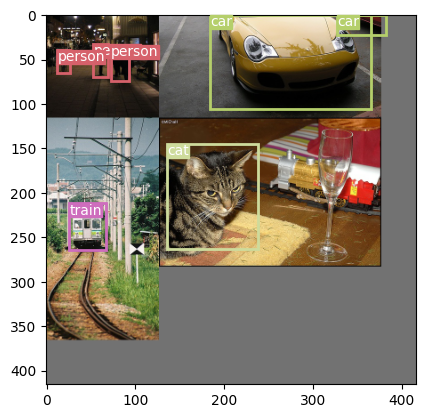

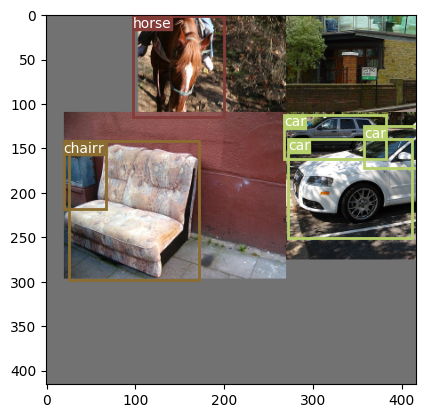

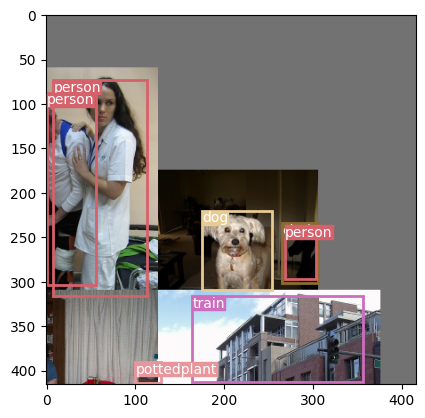

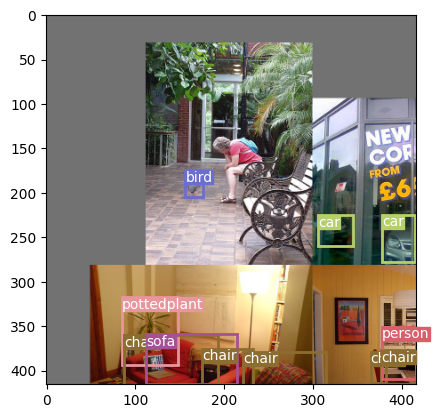

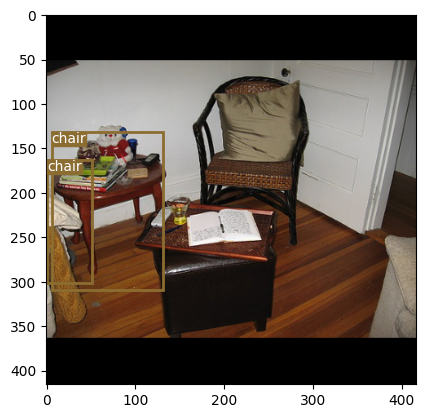

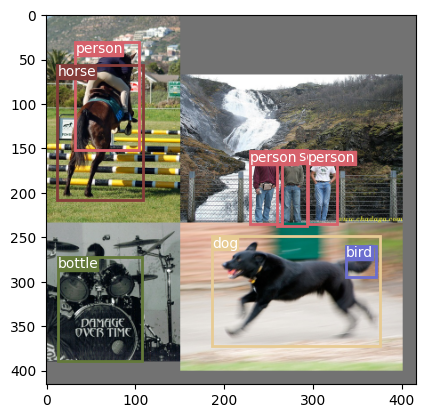

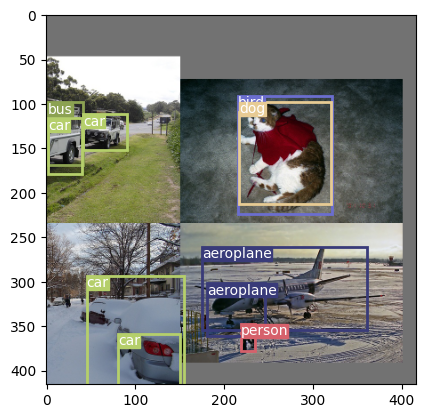

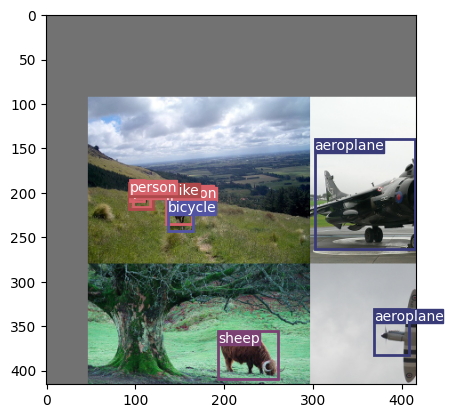

In [5]:
# test 1 example
# plot examples
device ='cuda'
scaled_anchors   = (torch.tensor(config.ANCHORS) * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(config.DEVICE)
plot_couple_examples(inference_model.to(device), test_loader, 0.6, 0.5, scaled_anchors)

In [6]:
# check the model's test accuracy by loading from save_checkpoint and without mosaic
print(f"----------Model Performance after loading from saved checkpoint----------")
trainer = Trainer(log_every_n_steps=1,
                  check_val_every_n_epoch=1,
    enable_model_summary=True,
    max_epochs=2,
    precision=16,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger= TensorBoardLogger("logs/"),
    default_root_dir="model/save/",
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],)
trainer.test(inference_model, test_loader)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


----------Model Performance after loading from saved checkpoint----------


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     class_accuracy          84.62405395507812
   no_object_accuracy        98.20870971679688
     object_accuracy         78.06748962402344
        test_loss            4.723134994506836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 4.723134994506836,
  'class_accuracy': 84.62405395507812,
  'no_object_accuracy': 98.20870971679688,
  'object_accuracy': 78.06748962402344}]

In [7]:
# check class accuracy using utils
device ='cuda'
check_class_accuracy(inference_model.to(device), test_loader, threshold=config.CONF_THRESHOLD)

100%|██████████| 155/155 [00:49<00:00,  3.12it/s]

Class accuracy is: 84.499207%
No obj accuracy is: 98.179016%
Obj accuracy is: 78.118385%
